In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.gating.utilities import centroid, multi_centroid_calculation
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.neighbors import KDTree
from sklearn.cluster import DBSCAN, KMeans
from multiprocessing import Pool, cpu_count
from functools import partial
from itertools import cycle
from datetime import datetime
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pymongo
import pandas as pd
import numpy as np
import functools
import warnings
import os
warnings.filterwarnings('ignore')
test_init()

In [3]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [4]:
samples = exp.list_samples()
samples = [x for x in samples if x!= 'sep6']

In [5]:
for x in samples:
    hc = Gating(exp, x)
    print(f'----------------------------{x}----------------------------')
    print('Populations')
    print(hc.populations.keys())
    print('Gates')
    print(hc.gates.keys())
    print(f'--------------------------------------------------------------')
    

Continuing with blank Gating object. Check that populations have not been removed.
----------------------------hc1----------------------------
Populations
dict_keys(['root', 'cells', 'debris', 'lymphocytes', 'other_cells'])
Gates
dict_keys([])
--------------------------------------------------------------
Continuing with blank Gating object. Check that populations have not been removed.
----------------------------hc4----------------------------
Populations
dict_keys(['root', 'cells', 'debris', 'lymphocytes', 'other_cells'])
Gates
dict_keys([])
--------------------------------------------------------------
Continuing with blank Gating object. Check that populations have not been removed.
----------------------------hc5----------------------------
Populations
dict_keys(['root', 'cells', 'debris', 'lymphocytes', 'other_cells'])
Gates
dict_keys([])
--------------------------------------------------------------
Continuing with blank Gating object. Check that populations have not been remov

In [5]:
hc = Gating(exp, 'hc1')

In [225]:
gating_performance = dict(sample_id=[], population=[], method=[], accuracy=[], f1_score=[],
                         precision=[], recall=[], fpr=[])

def check_performance(hc, manual_pop, auto_pop, method):
    parent = hc.get_population_df(hc.gates[method].parent)
    manual_pop_idx = hc.populations[manual_pop].index
    auto_pop_idx = hc.populations[auto_pop].index
    # Apply function and measure time taken
    gating_performance['sample_id'].append(hc.id)
    if manual_pop == 'lymphocytes':
        gating_performance['populations'].append('lymphocytes')
    else:
        gating_performance['population'].append(manual_pop.split('_')[1])
    gating_performance['method'].append(method)
    
    #Pull data
    parent['manual'], parent['auto'] = 0, 0
    parent['manual'] = parent['manual'].mask(parent.index.isin(manual_pop_idx), 1)
    parent['auto'] = parent['auto'].mask(parent.index.isin(auto_pop_idx), 1)
    
    # Rate performance of result
    recall = recall_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    precision = precision_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    accuracy = accuracy_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    f1 = f1_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    gating_performance['f1_score'].append(f1)
    gating_performance['accuracy'].append(accuracy)
    gating_performance['precision'].append(precision)
    gating_performance['recall'].append(recall)
    tn, fp, fn, tp = confusion_matrix(y_pred=parent['auto'], y_true=parent['manual']).ravel()
    gating_performance['fpr'].append(fp/(fp+tn))

In [ ]:
for x in samples:
    print(f'Assessing performance for {x}')
    hc = Gating(exp, x)
    for method in ['gmm', 'dbscan', 'hdbscan', 'dens2d']:
        auto_pop = f'{method}_lymphocytes'
        check_performance(hc, 'lymphocytes', auto_pop, method)
        
        auto_pop = f'{method}_liveCD3'
        check_performance(hc, 'manual_liveCD3', auto_pop, method)
        
        auto_pop = f'{method}_gdt'
        check_performance(hc, 'manual_gdt', auto_pop, method)
        
        auto_pop = f'{method}_nongdt'
        check_performance(hc, 'manual_nongdt', auto_pop, method)

In [7]:
hc = Gating(exp, 'hc19')
data = apply_transform(hc.get_population_df('manual_liveCD3'), ['PanGD', 'Vd2'], 'logicle')

In [20]:
auto_gdt_geom = hc.populations['hdbscan_gdt'].geom
x1 = auto_gdt_geom['cords']['x']
y1 = auto_gdt_geom['cords']['y']

auto_nongdt_geom = hc.populations['hdbscan_nongdt'].geom
x2 = auto_nongdt_geom['cords']['x']
y2 = auto_nongdt_geom['cords']['y']

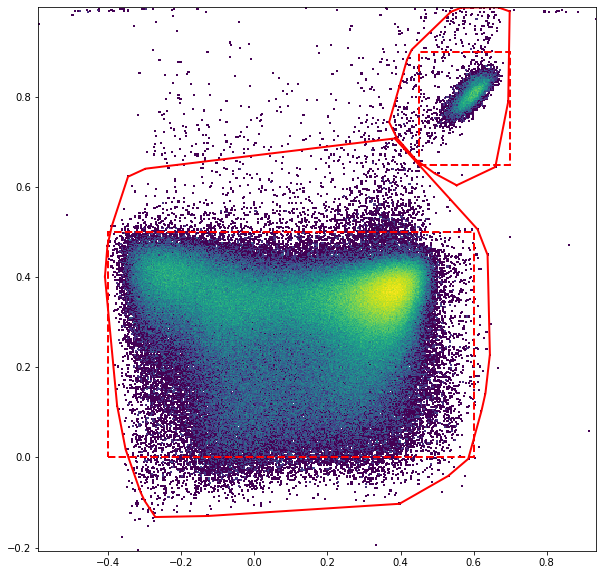

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist2d(data['PanGD'], data['Vd2'], bins=500, norm=LogNorm())
manual_rect = Rectangle(xy=(0.45, 0.65), width=0.25, height=0.25, fill=None, color='r', linestyle='--', linewidth=2)
ax.add_patch(manual_rect)
manual_rect = Rectangle(xy=(-0.4, 0), width=1, height=0.5, fill=None, color='r', linestyle='--', linewidth=2)
ax.add_patch(manual_rect)
ax.plot(x1, y1, '-k', c='r', linewidth=2)
ax.plot(x2, y2, '-k', c='r', linewidth=2)
fig.show()

In [226]:
for x in samples:
    print(f'Assessing performance for {x}')
    hc = Gating(exp, x)
    try:
        for method in ['gmm', 'dbscan', 'hdbscan', 'dens2d']:
            auto_pop = f'{method}_lymphocytes'
            check_performance(hc, 'manual_lymphocytes', auto_pop, auto_pop)
    except:
        print(f'{x} FAILED')

Assessing performance for hc1
Assessing performance for hc4
Assessing performance for hc5
hc5 FAILED
Assessing performance for hc7
hc7 FAILED
Assessing performance for hc9
Assessing performance for hc10
Assessing performance for hc11
Assessing performance for hc12
Assessing performance for hc13
Assessing performance for hc15
Assessing performance for hc16
Assessing performance for hc17
Assessing performance for hc18
Assessing performance for hc19


In [227]:
for x in samples:
    print(f'Assessing performance for {x}')
    hc = Gating(exp, x)
    try:
        for method in ['gmm', 'dbscan', 'hdbscan', 'dens2d']:
            auto_pop = f'{method}_gdt'
            check_performance(hc, 'manual_gdt', auto_pop, auto_pop)
    except:
        print(f'{x} FAILED')

Assessing performance for hc1
Assessing performance for hc4
Assessing performance for hc5
hc5 FAILED
Assessing performance for hc7
Assessing performance for hc9
Assessing performance for hc10
Assessing performance for hc11
Assessing performance for hc12
Assessing performance for hc13
Assessing performance for hc15
Assessing performance for hc16
Assessing performance for hc17
Assessing performance for hc18
Assessing performance for hc19


In [229]:
def rename_method(x):
    if x.split('_')[0] == 'gmm':
        return 'Gaussian Mixture Model'
    if x.split('_')[0] == 'dbscan':
        return 'DBSCAN'
    if x.split('_')[0] == 'hdbscan':
        return 'HDBSCAN'
    if x.split('_')[0] == 'dens2d':
        return 'Density threshold (2D)'
    return x
results = pd.DataFrame(gating_performance)
results['method'] = results['method'].apply(rename_method)

(0, 1)

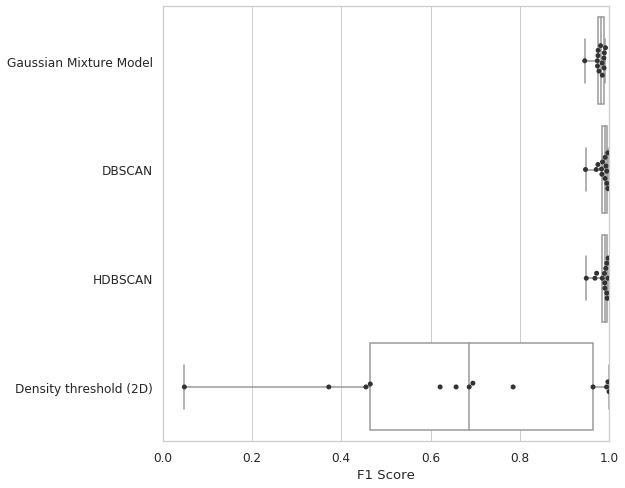

In [248]:
import seaborn as sns
sns.set(font_scale=1.1)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,8))
d = results[results['population'] == 'gdt']
ax = sns.boxplot(x="f1_score", y="method", data=d, whis=np.inf, color='white')
ax = sns.swarmplot(x="f1_score", y="method", data=d, color='.2')
ax.set_xlabel('F1 Score')
ax.set_ylabel('')
ax.set_xlim(0,1)

In [231]:
results.population.unique()

array(['lymphocytes', 'gdt'], dtype=object)